©2022, Altdeep, Inc. All rights   Visit Altdeep.ai for content related to this notebook.

# Resolving Newcomb's Paradox with a Causal Model

A famous thought experiment called [Newcomb's paradox](https://en.wikipedia.org/wiki/Newcomb's_paradox) attempts to show how causal decision theory would produce suboptimal results relative to non-causal methods.  It also shows how a dominant (admissible) decision rule is not necessarily the rule that maximizes expected utility.  In this tutorial, we'll implement the analysis in code and show how to resolve the paradox.

First, I install and load the libraries.

In [1]:
# !pip install pgmpy

In [2]:
import networkx as nx

from pgmpy.models import BayesianNetwork as bn
from pgmpy.inference import BeliefPropagation, VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor

import pylab as plt

Next, I implement the ideal intervention, weighted mean, and expected utility helper functions.

In [3]:
def do(model, interventions):
    """ 
    Implement an ideal intervention for discrete variables. Modifies pgmpy's
    `do` method so it is a `do`-operator, meaning a function that takes in a
    model, modifies it with an ideal intervention, and returns a new model.
    Note that this code would need to be modified to work for continuous
    variables.
    """
    def _mod_kernel(kernel, int_val):
        """
        Modify a causal Markov kernel so all probability is on the state fixed
        by the intervention.
        """ 
        var_name = kernel.variable
        card = kernel.get_cardinality([var_name])[var_name]
        states = [kernel.get_state_names(var_name, i) for i in range(card)]
        non_int_states = set(states) - {int_val,}
        unordered_prob_vals = [[1.0]] + [[0.0] for _ in range(card - 1)]
        unordered_states = [int_val] + list(non_int_states)
        # Reorder so it matches original
        dict_ = dict(zip(unordered_states, unordered_prob_vals))
        ordered_prob_values = [dict_[k] for k in states]
        intervention_kernel = TabularCPD(
            var_name, card, ordered_prob_values,
            state_names = {var_name: states}
        )
        return intervention_kernel

    kernels = {kern.variable: kern for kern in model.get_cpds()}
    new_model = model.copy()
    for var, int_val in interventions.items():
        new_model = new_model.do(var)
        new_kernel = _mod_kernel(kernels[var], int_val)
        new_model.add_cpds(new_kernel)
    return new_model

def weighted_mean(vals, weights):
    """
    Calculate a weighted mean
    """
    assert len(vals) == len(weights)
    norm = sum(weights)
    probs = [w/norm for w in weights]
    mean = sum(val * p for val, p in zip(vals, probs))
    return mean

def get_expected_utility(inference_result: DiscreteFactor, u_node: str="U"):
    """
    Calculate expected utility from the output of an inference algorithm
    """
    utilities = inference_result.state_names[u_node]
    probs = inference_result.values
    return weighted_mean(utilities, probs)

def get_expected_utility_given_evidence(model, evidence, u_node="U",
                                        inference_engine=VariableElimination):
    """
    Calculate expected utility from the output of an inference algorithm
    """
    engine = inference_engine(model)
    inference_result = engine.query([u_node], evidence=evidence)
    expected_u = get_expected_utility(inference_result, u_node)
    return expected_u

def get_expected_utility_given_interventions(model, interventions, u_node="U",
                                            inference_engine=VariableElimination):
    int_model = do(model, interventions)
    expected_u = get_expected_utility_given_evidence(
        int_model,
        evidence=interventions,
        u_node=u_node,
        inference_engine=inference_engine
    )
    return expected_u


## Newcomb's Paradox

Consider the following thought experiment.  There are two boxes designated A and B.  Box A always contains 1,000 dollars.  Box B contains either 1,000,000 or 0.  The decision-making agent must choose between taking only box B or *both* boxes.  The agent does not know what is in box B until they decide.

![newcomb-boxes](https://raw.githubusercontent.com/altdeep/causalML/master/tutorials/fig/newcomb-boxes.jpg)

Obviously, the agent should take both boxes.  However, we then add a complicating factor.  There is an adversarial AI that can predict with high accuracy what the agent will do.  That AI can set the contents of box B to minimize the agent's winnings.  If the AI predicts the agent will take both boxes, it will put no money in box B.  If the AI predicts that the agent will take only box B, it will put 1,000,000 in box B.  The agent does not know what the AI predicted or what box B contains when they make their choice.

The paradox arises as follows.  For context, when decision theories defined "causal decision theory," they did so without causal DAGs or programs.  They defined "causal decision theory" to mean that the agent should only attend to the consequences of their actions.  Remember that the AI makes the prediction *before* the agent acts.  Since effects cannot precede causes in time, the AI's behavior is not a consequence of the agent's actions.  Therefore, if we accept this definition of "causal decision theory," the agent who only attends to the consequences of its actions will ignore the AI.  And so it will take both boxes.

In causal notation, the causal agent the probable values of utility given do(choice=x).  Note that, no matter what is in box B, U|do(choice=both) - U|do(choice=B) is always 1,000.  As a result, E(U|do(choice=both)) - E(U|do(choice=B)) is 1000.  The decision rule that chooses the choice x that maximizes E(U|do(choice=x)) is admissible.  We have admissibility because the solution that maximizes E(U|do(choice=x)) that x is "both" and choosing "both" always [dominates](https://en.wikipedia.org/wiki/Dominating_decision_rule) choosing only "B."

Decision theorists contrast "causal decision theory" with "evidential decision theory," which suggests we should choose the action x that maximizes E(U|choice=x) instead of E(U|do(choice=x).  The term "evidential" comes from the idea that we could calculate E(U|choice) by learning P(U|choice), which we do by observing {choice, U} outcomes.

Let's assume the predictive algorithm is 95\% accurate.  If the agent chooses both, there is a 95\% chance the predictive algorithm will have guessed that and put no money in B, in which case the agent only gets the 1,000.  There is a 5\% chance the algorithm will guess wrong, in which case it puts 1,000,000 in box B, and the agent wins 1,001,000.  The expected utility calculation is $1000 * .95 + 1,001,000 * 0.05 = 51,000$.

If the agent chooses B, there is a 95\% chance the algorithm will have guessed it and will place the 1,000,000 in B.  There is a 5\% chance the algorithm gets it wrong and puts 0 in B.  So the expected utility is $1,000,000 * .95 + 0 * 0.05 = 950,000$.

So by the decision rule of maximizing E(U|choice), choosing box B is optimal.  A cursory glance at the expectation math will show this result holds if we change 95\% accuracy to other high accuracy numbers for the predictive algorithm.

```
Predicted choice 	Box B Content   Choice    Utility       
both                $0              B 	     $0      
both                $0              both 	  $1,000       
B 	              $1,000,000      B 	     $1,000,000
B                   $1,000,000      both 	  $1,001,000   

```

So the paradox is that "evidential decision theory" and this version of causal decision theory tell you to do different things.  Further, the choice that always makes $1,000 more than the other choice is not the choice that maximizes expected utility, which is unusual.

But as causal modelers, we are not surprised that the choice that maximizes E(U|choice) is different from the choice that maximizes E(U|do(choice)).  So let us see if we can resolve the paradox with a model.

## Modeling Newcomb's Paradox with a Causal Model

We can resolve Newcomb's Paradox with a causal model.  In this tutorial, I implement the model using a causal graphical model in `pgmpy`.

Before we consider the AI, we have the following model.



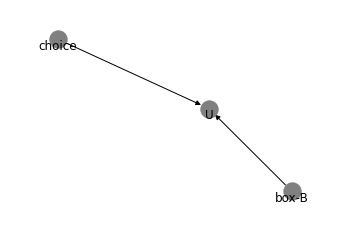

In [4]:
model = bn()
model.add_edges_from(
    [
      ('choice','U'),
      ('box-B','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15) 
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()

The choice of the agent (Box B only or both boxes A and B) and the contents of Box B are independent causes of the agent's utility.  We don't model the context of Box A explicitly since it is a constant.

### Adding bias to the model

Suppose the agent is predisposed to making a choice.  For example, when I am faced with a decision of eating or not eating roasted almonds covered in dark chocolate and sea salt, I am biased towards eating!  Let's expand the model to capture bias.

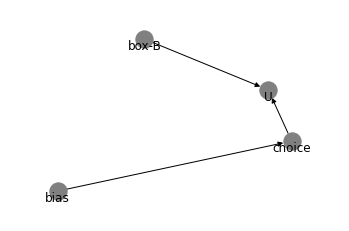

In [5]:
model = bn()
model.add_edges_from(
    [
      ('bias','choice'),
      ('choice','U'),
      ('box-B','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15) 
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()

Bias allows us to introduce the AI.  We suppose that the AI knows the agent's bias and uses it to make a prediction.  That prediction determines what goes into Box B. 

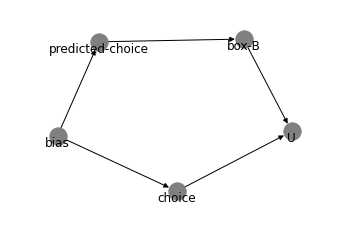

In [6]:
model = bn()
model.add_edges_from(
    [
      ('bias','predicted-choice'),
      ('bias','choice'),
      ('predicted-choice','box-B'),
      ('choice','U'),
      ('box-B','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15) 
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()

## Building the model

Let's continue building the model.  Next we parameterize the causal Markov kernels.

In [7]:
kernel_bias = TabularCPD(
    'bias', 2, [[.5], [.5]],
    state_names= {'bias': ['B', 'both']}
)
print(kernel_bias)

+------------+-----+
| bias(B)    | 0.5 |
+------------+-----+
| bias(both) | 0.5 |
+------------+-----+


In [8]:
kernel_choice = TabularCPD('choice', 2, [[1, 0], [0, 1]], 
                      evidence=['bias'], evidence_card=[2],
                      state_names = {
                          'choice': ['B', 'both'],
                          'bias': ['B', 'both']
                      })
print(kernel_choice)

+--------------+---------+------------+
| bias         | bias(B) | bias(both) |
+--------------+---------+------------+
| choice(B)    | 1.0     | 0.0        |
+--------------+---------+------------+
| choice(both) | 0.0     | 1.0        |
+--------------+---------+------------+


The accuracy of the prediction is captured in the causal Markov kernel for predicted-choice.  The more the agent knows our bias, the more accurate is its model it has of P(predicted-choice|bias).

In [9]:
kernel_prediction = TabularCPD('predicted-choice', 2, [[.95, 0.05], [.05, .95]], 
                      evidence=['bias'], evidence_card=[2],
                      state_names = {
                          'predicted-choice': ['B', 'both'],
                          'bias': ['B', 'both']
                      })
print(kernel_prediction)

+------------------------+---------+------------+
| bias                   | bias(B) | bias(both) |
+------------------------+---------+------------+
| predicted-choice(B)    | 0.95    | 0.05       |
+------------------------+---------+------------+
| predicted-choice(both) | 0.05    | 0.95       |
+------------------------+---------+------------+


In [10]:
kernel_box_b = TabularCPD('box-B', 2, [[0, 1], [1, 0]], 
                      evidence=['predicted-choice'], evidence_card=[2],
                      state_names = {
                          'box-B': [0, 1000000],
                          'predicted-choice': ['B', 'both']
                      })
print(kernel_box_b)

+------------------+---------------------+------------------------+
| predicted-choice | predicted-choice(B) | predicted-choice(both) |
+------------------+---------------------+------------------------+
| box-B(0)         | 0.0                 | 1.0                    |
+------------------+---------------------+------------------------+
| box-B(1000000)   | 1.0                 | 0.0                    |
+------------------+---------------------+------------------------+


In [11]:
kernel_u = TabularCPD('U', 4, 
                        [
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1],
                        ],
                        evidence=['box-B','choice'], evidence_card=[2, 2],
                        state_names = {
                            'U': [0, 1000, 1000000, 1001000],
                            'box-B': [0, 1000000],
                            'choice': ['B', 'both']
                        }
                      )
print(kernel_u)

+------------+-----------+--------------+----------------+----------------+
| box-B      | box-B(0)  | box-B(0)     | box-B(1000000) | box-B(1000000) |
+------------+-----------+--------------+----------------+----------------+
| choice     | choice(B) | choice(both) | choice(B)      | choice(both)   |
+------------+-----------+--------------+----------------+----------------+
| U(0)       | 1.0       | 0.0          | 0.0            | 0.0            |
+------------+-----------+--------------+----------------+----------------+
| U(1000)    | 0.0       | 1.0          | 0.0            | 0.0            |
+------------+-----------+--------------+----------------+----------------+
| U(1000000) | 0.0       | 0.0          | 1.0            | 0.0            |
+------------+-----------+--------------+----------------+----------------+
| U(1001000) | 0.0       | 0.0          | 0.0            | 1.0            |
+------------+-----------+--------------+----------------+----------------+


In [12]:
model.add_cpds(kernel_bias, kernel_prediction, kernel_box_b, kernel_choice, kernel_u)

## Calculating expected utility

The "evidential decision theory" approach looks only at E(U|choice).  We can calculate this value for both choices using inference on the graphical model.

In [13]:
u_given_b = get_expected_utility_given_evidence(model, evidence = {'choice': 'B'})
u_given_both = get_expected_utility_given_evidence(model, evidence = {'choice': 'both'})
print("E(U|choice=B) = " + str(u_given_b) + "\n")
print("E(U|choice=both) = " + str(u_given_both) + "\n")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

E(U|choice=B) = 950000.0

E(U|choice=both) = 51000.0



When the agent "attends only to the consquences of their actions", it just considers E(U|do(choice)). We can show that E(U|do(choice=both)) - E(U|do(choice=B)) is $1000.

In [14]:
u_given_do_b = get_expected_utility_given_interventions(model, interventions = {'choice': 'B'})
u_given_do_both = get_expected_utility_given_interventions(model, interventions = {'choice': 'both'})
print("E(U|do(choice=B)) = " + str(u_given_do_b) + "\n")
print("E(U|do(choice=both)) = " + str(u_given_do_both) + "\n")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

E(U|do(choice=B)) = 500000.0

E(U|do(choice=both)) = 501000.0



## Resolving the paradox

`do` models an ideal intervention that which can block influence of an agent's *bias* on their *choice*.  How might we achieve this in practice?

Suppose the agent had their own AI, a virtual assistant that cared about optimizing the agent's utility function.  Like the adversarial AI, it knows the bias of the agent.  Unlike, the adversarial AI, it wants the agent to win.  Given the agent's bias, it predicts what the adversarial AI will do in response to the bias, and then recommends the optimal decision to the agent. 

In [15]:
def dict_argmax(d: dict):
    """Returns key with greatest value"""
    return max(d, key=lambda k: d[k])

In [16]:
# max(d) returns the largest key, NOT the key with the largest value
d = {"B":100, "both":1000}
print(dict_argmax(d), max(d))

d = {"B":1000, "both":100}
print(dict_argmax(d), max(d))

both both
B both


In [17]:
def decide_for_agent(model, bias):
    utilities = {}
    for intervention in ['both', 'B']:
        int_model = do(model, {'choice': intervention})
        expected_u = get_expected_utility_given_evidence(
            int_model,
            evidence= {
                'bias': bias
            },
        )
        utilities[intervention] = expected_u
    return utilities


decision_d = dict()
for bias in ["B", "both"]:
    decision_d[bias] = decide_for_agent(model, bias=bias)

for bias, decision in decision_d.items():

    print(f"Dear agent, you are biased towards {bias}.")
    decision_max = dict_argmax(decision)
    print(f"You should choose " + str(decision_max) + ".")
    print(decision)
    print("")



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dear agent, you are biased towards B.
You should choose both.
{'both': 951000.0, 'B': 950000.0}

Dear agent, you are biased towards both.
You should choose both.
{'both': 51000.0, 'B': 50000.0}



## Counter-bias AI

Let's setup a scenario where the optimal action is always to act counter to one's bias. This will have a similar but less paradoxical setup to Newcomb's paradox.

The player can choose box B (blue) or G (green). The player's natural bias is to choose the box whose color they prefer. An adversarial AI knows the player's favorite color, and put's nothing in the box of that color, and \$100 in the other box.

Helper functions

The kernel printer truncates the `kernel_u` table for some reason, so let's re-implement it without the truncation.

In [18]:
import numpy as np
from itertools import product
from pgmpy.extern import tabulate
def _make_table_str_untruncated(self, tablefmt="grid", print_state_names=True, truncate=False):
    headers_list = []

    # Build column headers
    evidence = self.variables[1:]
    evidence_card = self.cardinality[1:]
    if evidence:
        col_indexes = np.array(list(product(*[range(i) for i in evidence_card])))
        if self.state_names and print_state_names:
            for i in range(len(evidence_card)):
                column_header = [str(evidence[i])] + [
                    "{var}({state})".format(
                        var=evidence[i], state=self.state_names[evidence[i]][d]
                    )
                    for d in col_indexes.T[i]
                ]
                headers_list.append(column_header)
        else:
            for i in range(len(evidence_card)):
                column_header = [str(evidence[i])] + [
                    f"{evidence[i]}_{d}" for d in col_indexes.T[i]
                ]
                headers_list.append(column_header)

    # Build row headers
    if self.state_names and print_state_names:
        variable_array = [
            [
                "{var}({state})".format(
                    var=self.variable, state=self.state_names[self.variable][i]
                )
                for i in range(self.variable_card)
            ]
        ]
    else:
        variable_array = [
            [f"{self.variable}_{i}" for i in range(self.variable_card)]
        ]
    # Stack with data
    labeled_rows = np.hstack(
        (np.array(variable_array).T, self.get_values())
    ).tolist()
    # No support for multi-headers in tabulate
    cdf_str = tabulate(headers_list + labeled_rows, tablefmt=tablefmt)

    if truncate:
        cdf_str = self._truncate_strtable(cdf_str)

    return cdf_str

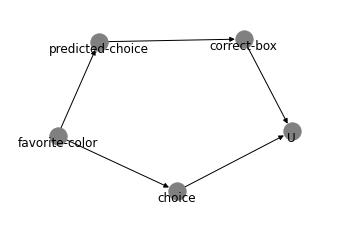

In [19]:
model = bn()
model.add_edges_from(
    [
      ('favorite-color','predicted-choice'),
      ('favorite-color','choice'),
      ('predicted-choice','correct-box'),
      ('choice','U'),
      ('correct-box','U'),
    ]
)
ax1 = plt.subplot(111)
ax1.margins(0.15) 
pos = nx.nx_pydot.graphviz_layout(model)
nx.draw(model, pos, ax=ax1, with_labels=True, node_color='grey', verticalalignment='top')
plt.show()

In [20]:
kernel_favorite_color = TabularCPD(
    'favorite-color', 2, [[.5], [.5]],
    state_names= {'favorite-color': ['blue', 'green']}
)
print(kernel_favorite_color)

+-----------------------+-----+
| favorite-color(blue)  | 0.5 |
+-----------------------+-----+
| favorite-color(green) | 0.5 |
+-----------------------+-----+


In [21]:
kernel_prediction = TabularCPD(
    # 'predicted-choice', 2, [[.95, 0.05], [.05, .95]], 
    'predicted-choice', 2, [[1, 0], [0, 1]], 

                      evidence=['favorite-color'], evidence_card=[2],
                      state_names = {
                          'predicted-choice': ['blue', 'green'],
                          'favorite-color': ['blue', 'green']
                      })
print(kernel_prediction)

+-------------------------+----------------------+-----------------------+
| favorite-color          | favorite-color(blue) | favorite-color(green) |
+-------------------------+----------------------+-----------------------+
| predicted-choice(blue)  | 1.0                  | 0.0                   |
+-------------------------+----------------------+-----------------------+
| predicted-choice(green) | 0.0                  | 1.0                   |
+-------------------------+----------------------+-----------------------+


In [22]:
kernel_choice = TabularCPD('choice', 2, [[1, 0], [0, 1]], 
                      evidence=['favorite-color'], evidence_card=[2],
                      state_names = {
                          'choice': ['blue', 'green'],
                          'favorite-color': ['blue', 'green']
                      })
print(kernel_choice)

+----------------+----------------------+-----------------------+
| favorite-color | favorite-color(blue) | favorite-color(green) |
+----------------+----------------------+-----------------------+
| choice(blue)   | 1.0                  | 0.0                   |
+----------------+----------------------+-----------------------+
| choice(green)  | 0.0                  | 1.0                   |
+----------------+----------------------+-----------------------+


In [23]:
kernel_correct_box = TabularCPD('correct-box', 2, [[0, 1], [1, 0]], 
                      evidence=['predicted-choice'], evidence_card=[2],
                      state_names = {
                          'correct-box': ["blue", "green"],
                          'predicted-choice': ['blue', 'green']
                      })
print(kernel_correct_box)

+--------------------+------------------------+-------------------------+
| predicted-choice   | predicted-choice(blue) | predicted-choice(green) |
+--------------------+------------------------+-------------------------+
| correct-box(blue)  | 0.0                    | 1.0                     |
+--------------------+------------------------+-------------------------+
| correct-box(green) | 1.0                    | 0.0                     |
+--------------------+------------------------+-------------------------+


In [24]:
kernel_u = TabularCPD('U', 2, 
                        [
                            [0,1,1,0],
                            [1,0,0,1]
                        ],
                        evidence=['correct-box','choice'], evidence_card=[2, 2],
                        state_names = {
                            'U': [0, 1000000],
                            'correct-box': ["blue", "green"],
                            'choice': ['blue', 'green']
                        }
                      )
print(_make_table_str_untruncated(kernel_u))


+-------------+-------------------+-------------------+--------------------+--------------------+
| correct-box | correct-box(blue) | correct-box(blue) | correct-box(green) | correct-box(green) |
+-------------+-------------------+-------------------+--------------------+--------------------+
| choice      | choice(blue)      | choice(green)     | choice(blue)       | choice(green)      |
+-------------+-------------------+-------------------+--------------------+--------------------+
| U(0)        | 0.0               | 1.0               | 1.0                | 0.0                |
+-------------+-------------------+-------------------+--------------------+--------------------+
| U(1000000)  | 1.0               | 0.0               | 0.0                | 1.0                |
+-------------+-------------------+-------------------+--------------------+--------------------+


In [25]:
model.add_cpds(kernel_favorite_color, kernel_prediction, kernel_correct_box, kernel_choice, kernel_u)

In [26]:
u_given_choice_d = dict()
for choice in ["blue", "green"]:
    u_given_choice_d[choice] =  get_expected_utility_given_evidence(model, evidence = {'choice': choice})

for choice, u in u_given_choice_d.items():
    print(f"E(U|choice={choice}) = " + str(u_given_choice_d[choice]) + "\n")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

E(U|choice=blue) = 0.0

E(U|choice=green) = 0.0



In [27]:
u_given_do_choice_d = dict()
for choice in ["blue", "green"]:
    u_given_do_choice_d[choice] =  get_expected_utility_given_interventions(model, interventions = {'choice': choice})

for choice, u in u_given_do_choice_d.items():
    print(f"E(U|do(choice={choice})) = " + str(u_given_do_choice_d[choice]) + "\n")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

E(U|do(choice=blue)) = 500000.0

E(U|do(choice=green)) = 500000.0



In [28]:
def decide_for_agent(model, favorite_color):
    utilities = {}
    for intervention in ['blue', 'green']:
        int_model = do(model, {'choice': intervention})
        expected_u = get_expected_utility_given_evidence(
            int_model,
            evidence= {
                'favorite-color': favorite_color
            },
        )
        utilities[intervention] = expected_u
    return utilities


# message_d = dict()
decision_d = dict()
for favorite_color in ["blue", "green"]:
    decision_d[favorite_color] = decide_for_agent(model, favorite_color=favorite_color)

for favorite_color, decision in decision_d.items():

    print(f"Dear agent, you are biased towards {favorite_color}.")
    decision_max = dict_argmax(decision)
    print(f"You should choose " + str(decision_max) + ".")
    print(decision)
    print("")


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dear agent, you are biased towards blue.
You should choose green.
{'blue': 0.0, 'green': 1000000.0}

Dear agent, you are biased towards green.
You should choose blue.
{'blue': 1000000.0, 'green': 0.0}

